In [1]:
import pandas as pd
data = pd.read_csv('clean_data.csv')
data.age_group.value_counts()

age_group
10-14 years      5600
15-19 years      5600
20-24 years      5600
25-29 years      5600
30-34 years      5600
35-39 years      5600
40-44 years      5600
45-49 years      5600
50-54 years      5600
55-59 years      5600
60-64 years      5600
65-69 years      5600
70-74 years      5600
75-79 years      5600
80+ years        5600
15-49 years      5600
50-69 years      5600
80-84 years      5600
50-74 years      5600
10-24 years      5600
10-19 years      5600
10 - 54 years    5600
15-39 years      5600
65-74 years      5600
75-84 years      5600
20-54 years      5600
Name: count, dtype: int64

In [3]:
# Define the desired age groups
desired_age_groups = [
    '10-14 years',
    '15-19 years',
    '20-24 years',
    '25-29 years',
    '30-34 years',
    '35-39 years',
    '40-44 years',
    '45-49 years',
    '50-54 years',
    '55-59 years',
    '60-64 years',
    '65-69 years',
    '70-74 years',
    '75-79 years',
    '80+ years'
]

# Filter the DataFrame
data = data[data['age_group'].isin(desired_age_groups)]


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84000 entries, 0 to 145577
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country_name                    84000 non-null  object 
 1   gender                          84000 non-null  object 
 2   age_group                       84000 non-null  object 
 3   year                            84000 non-null  int64  
 4   suicide_rate/100k               84000 non-null  float64
 5   country_code                    84000 non-null  object 
 6   alcohol_consumption_per_capita  84000 non-null  float64
 7   depression_rate                 84000 non-null  float64
 8   gdp_per_capita                  84000 non-null  float64
 9   HDI                             84000 non-null  float64
 10  life_expectancy                 84000 non-null  float64
 11  unemployment_rate               84000 non-null  float64
dtypes: float64(7), int64(1), object(4)
m

In [5]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Encode 'gender'
le_sex = LabelEncoder()
data['gender_enc'] = le_sex.fit_transform(data['gender'])

# Encode 'age_group'
ord_age = OrdinalEncoder(categories=[desired_age_groups])
data['age_enc'] = ord_age.fit_transform(data[['age_group']]).astype(int)

# drop country_code
data = data.drop(['gender', 'age_group', 'country_code'], axis=1)

data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 84000 entries, 0 to 145577
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country_name                    84000 non-null  object 
 1   year                            84000 non-null  int64  
 2   suicide_rate/100k               84000 non-null  float64
 3   alcohol_consumption_per_capita  84000 non-null  float64
 4   depression_rate                 84000 non-null  float64
 5   gdp_per_capita                  84000 non-null  float64
 6   HDI                             84000 non-null  float64
 7   life_expectancy                 84000 non-null  float64
 8   unemployment_rate               84000 non-null  float64
 9   gender_enc                      84000 non-null  int64  
 10  age_enc                         84000 non-null  int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 7.7+ MB


In [6]:
data.country_name.nunique()

144

In [6]:
import pandas as pd

# Step 1: Group by country_name and year to count rows
country_name_year_counts = data.groupby(['country_name', 'year']).size().reset_index(name='count')

# Step 2: Count how many unique years each country_name appears in
years_per_country_name = country_name_year_counts.groupby('country_name')['year'].nunique().reset_index()
years_per_country_name.columns = ['country_name', 'years_present']

# Step 3: Count total rows per country_name
rows_per_country_name = data['country_name'].value_counts().reset_index()
rows_per_country_name.columns = ['country_name', 'total_rows']

# Step 4: Merge both stats into one DataFrame
country_name_stats = pd.merge(years_per_country_name, rows_per_country_name, on='country_name')

# Step 5: Sort to identify countries with low representation
country_name_stats = country_name_stats.sort_values(by=['years_present', 'total_rows'])

# Step 6: Show countries with few years or few total rows
low_rep_threshold_years = 10     # adjust this as needed
low_rep_threshold_rows = 100     # adjust this as needed
low_rep_countries = country_name_stats[
    (country_name_stats['years_present'] < low_rep_threshold_years) |
    (country_name_stats['total_rows'] < low_rep_threshold_rows)
]

print("Low representation countries:")
print(low_rep_countries)

# Optional: Quick stats
print("\nSummary:")
print(f"Total countries: {country_name_stats.shape[0]}")
print(f"Countries with low representation: {low_rep_countries.shape[0]}")


Low representation countries:
   country_name  years_present  total_rows
36     Djibouti              7         210

Summary:
Total countries: 144
Countries with low representation: 1


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from category_encoders import TargetEncoder
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import category_encoders as ce

# Define features (X) and target (y)
y = data['suicide_rate/100k']
X = data.drop(['suicide_rate/100k'], axis=1)

# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# ---------------------- Target Encoding with K-Fold CV ----------------------

# (a) Create an empty Series to collect fold-wise encodings
country_te_train = pd.Series(index=X_train.index, dtype=float)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for tr_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr = y_train.iloc[tr_idx]
    
    te_fold = ce.TargetEncoder(cols=['country_name'])
    te_fold.fit(X_tr[['country_name']], y_tr)
    
    country_te_train.iloc[val_idx] = (
        te_fold.transform(X_val[['country_name']])['country_name']
    ).values

# (b) Fit a final encoder on *all* training data, for the test set
final_te = ce.TargetEncoder(cols=['country_name'])
final_te.fit(X_train[['country_name']], y_train)
country_te_test = final_te.transform(X_test[['country_name']])['country_name'].values

# (c) Drop the raw 'country_name' feature and insert the encoded versions
X_train_enc = X_train.drop(columns=['country_name']).copy()
X_train_enc['country_te'] = country_te_train

X_test_enc = X_test.drop(columns=['country_name']).copy()
X_test_enc['country_te'] = country_te_test


=== Cross-validating KNN ===
Training fold 1/10 for KNN...
Fold 1 - MAE: 1.8909, MSE: 18.9837, RMSE: 4.3570
Training fold 2/10 for KNN...
Fold 2 - MAE: 1.8261, MSE: 17.1370, RMSE: 4.1397
Training fold 3/10 for KNN...
Fold 3 - MAE: 1.8595, MSE: 18.2015, RMSE: 4.2663
Training fold 4/10 for KNN...
Fold 4 - MAE: 1.8967, MSE: 18.9243, RMSE: 4.3502
Training fold 5/10 for KNN...
Fold 5 - MAE: 1.8639, MSE: 17.8480, RMSE: 4.2247
Training fold 6/10 for KNN...
Fold 6 - MAE: 1.8347, MSE: 17.6248, RMSE: 4.1982
Training fold 7/10 for KNN...
Fold 7 - MAE: 1.8992, MSE: 18.7854, RMSE: 4.3342
Training fold 8/10 for KNN...
Fold 8 - MAE: 1.8295, MSE: 16.6738, RMSE: 4.0834
Training fold 9/10 for KNN...
Fold 9 - MAE: 1.8508, MSE: 19.4783, RMSE: 4.4134
Training fold 10/10 for KNN...
Fold 10 - MAE: 1.7604, MSE: 15.2745, RMSE: 3.9083
KNN - 10-fold CV Mean MAE: 1.8512, Mean MSE: 17.8931, Mean RMSE: 4.2275


=== Cross-validating Random Forest ===
Training fold 1/10 for Random Forest...
Fold 1 - MAE: 0.9199, MSE

c:\Users\maya2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 - MAE: 3.3907, MSE: 28.3018, RMSE: 5.3199
Training fold 2/10 for MLP...


c:\Users\maya2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 - MAE: 3.3834, MSE: 28.1738, RMSE: 5.3079
Training fold 3/10 for MLP...


c:\Users\maya2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 - MAE: 3.3493, MSE: 26.8710, RMSE: 5.1837
Training fold 4/10 for MLP...


c:\Users\maya2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 - MAE: 3.2898, MSE: 26.0403, RMSE: 5.1030
Training fold 5/10 for MLP...


c:\Users\maya2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 - MAE: 3.3416, MSE: 26.5759, RMSE: 5.1552
Training fold 6/10 for MLP...


c:\Users\maya2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 6 - MAE: 3.3516, MSE: 26.4129, RMSE: 5.1393
Training fold 7/10 for MLP...
Fold 7 - MAE: 3.3276, MSE: 27.3827, RMSE: 5.2329
Training fold 8/10 for MLP...


c:\Users\maya2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 8 - MAE: 3.3672, MSE: 28.1155, RMSE: 5.3024
Training fold 9/10 for MLP...


c:\Users\maya2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 9 - MAE: 3.3517, MSE: 26.6705, RMSE: 5.1643
Training fold 10/10 for MLP...


c:\Users\maya2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 10 - MAE: 3.3412, MSE: 26.2305, RMSE: 5.1216
MLP - 10-fold CV Mean MAE: 3.3494, Mean MSE: 27.0775, Mean RMSE: 5.2030


=== Cross-validating Linear Regression ===
Training fold 1/10 for Linear Regression...
Fold 1 - MAE: 10.9681, MSE: 284.1191, RMSE: 16.8558
Training fold 2/10 for Linear Regression...
Fold 2 - MAE: 10.8667, MSE: 279.4363, RMSE: 16.7163
Training fold 3/10 for Linear Regression...
Fold 3 - MAE: 10.9174, MSE: 288.2614, RMSE: 16.9783
Training fold 4/10 for Linear Regression...
Fold 4 - MAE: 11.1092, MSE: 296.4649, RMSE: 17.2182
Training fold 5/10 for Linear Regression...
Fold 5 - MAE: 10.9289, MSE: 286.6396, RMSE: 16.9304
Training fold 6/10 for Linear Regression...
Fold 6 - MAE: 10.8309, MSE: 274.0782, RMSE: 16.5553
Training fold 7/10 for Linear Regression...
Fold 7 - MAE: 10.6431, MSE: 276.2378, RMSE: 16.6204
Training fold 8/10 for Linear Regression...
Fold 8 - MAE: 10.5877, MSE: 261.7886, RMSE: 16.1799
Training fold 9/10 for Linear Regression...
Fold 9 - MAE: 11.0597

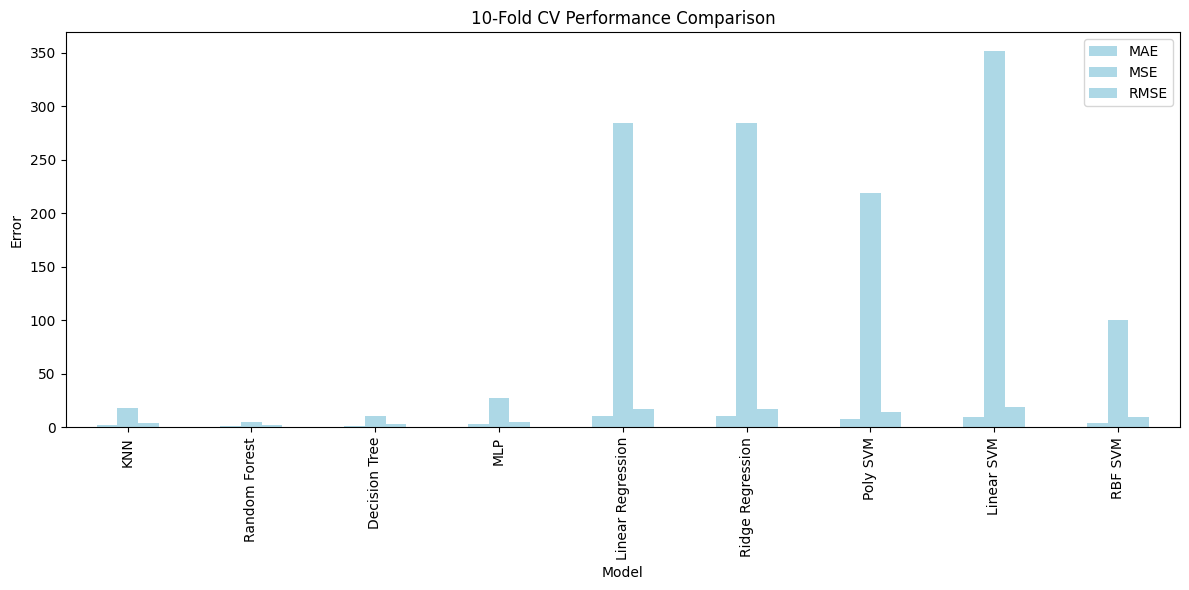

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR, LinearSVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

models = {
    'KNN': make_pipeline(StandardScaler(), KNeighborsRegressor()),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'MLP': make_pipeline(StandardScaler(), MLPRegressor(random_state=42, max_iter=500)),
    'Linear Regression': make_pipeline(StandardScaler(), LinearRegression()),
    'Ridge Regression': make_pipeline(StandardScaler(), Ridge(random_state=42)),
    'Poly SVM': make_pipeline(StandardScaler(), SVR(kernel='poly', degree=3, C=1, gamma='scale')),
    'Linear SVM': make_pipeline(StandardScaler(), LinearSVR(C=1.0, epsilon=0.1, max_iter=10000, random_state=42)),
    'RBF SVM': make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, gamma='scale')),
}


# 10-Fold cross-validation on the training set
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    print(f"\n=== Cross-validating {name} ===")
    fold_maes = []
    fold_mses = []
    fold_rmses = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_enc), 1):
        print(f"Training fold {fold}/10 for {name}...")
        X_tr, X_val = X_train_enc.iloc[train_idx], X_train_enc.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        fold_maes.append(mae)
        fold_mses.append(mse)
        fold_rmses.append(rmse)
        print(f"Fold {fold} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    
    cv_results.append({
        'Model': name,
        'MAE': np.mean(fold_maes),
        'MSE': np.mean(fold_mses),
        'RMSE': np.mean(fold_rmses)
    })
    print(f"{name} - 10-fold CV Mean MAE: {np.mean(fold_maes):.4f}, "
          f"Mean MSE: {np.mean(fold_mses):.4f}, Mean RMSE: {np.mean(fold_rmses):.4f}\n")

# Summarize CV results
df_cv = pd.DataFrame(cv_results).set_index('Model')
print("=== 10-Fold CV Results ===")
print(df_cv)

# Plot CV performance
ax = df_cv.plot(kind='bar', figsize=(12, 6), color='lightblue')
ax.set_title('10-Fold CV Performance Comparison')
ax.set_ylabel('Error')
plt.tight_layout()
plt.show()

In [9]:

# -----------------------------------------------------------------------------
# TEST SET EVALUATION
# -----------------------------------------------------------------------------

test_results = []
for name, model in models.items():
    print(f"\n=== Training {name} on full training set and evaluating on test set ===")
    model.fit(X_train_enc, y_train)
    y_pred_test = model.predict(X_test_enc)
    
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    mse_test  = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    
    test_results.append({
        'Model': name,
        'Test MAE': mae_test,
        'Test MSE': mse_test,
        'Test RMSE': rmse_test
    })
    print(f"{name} - Test MAE: {mae_test:.4f}, MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}")

# Summarize Test results
df_test = pd.DataFrame(test_results).set_index('Model')
print("\n=== Test Set Results ===")
print(df_test)

# Merge CV and Test results for comparison
df_combined = df_cv.join(df_test)
print("\n=== CV vs Test Comparison ===")
print(df_combined)

# visualize comparison side by side
# df_combined.plot(kind='bar', figsize=(14, 7), color=['lightblue', 'salmon'])
# plt.title('CV vs Test Error Comparison')
# plt.tight_layout()
# plt.show()



=== Training KNN on full training set and evaluating on test set ===
KNN - Test MAE: 1.7365, MSE: 14.9724, RMSE: 3.8694

=== Training Random Forest on full training set and evaluating on test set ===
Random Forest - Test MAE: 0.7552, MSE: 2.7796, RMSE: 1.6672

=== Training Decision Tree on full training set and evaluating on test set ===
Decision Tree - Test MAE: 0.9854, MSE: 9.0286, RMSE: 3.0048

=== Training MLP on full training set and evaluating on test set ===


c:\Users\maya2\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP - Test MAE: 3.3477, MSE: 27.0843, RMSE: 5.2043

=== Training Linear Regression on full training set and evaluating on test set ===
Linear Regression - Test MAE: 10.7971, MSE: 263.4838, RMSE: 16.2322

=== Training Ridge Regression on full training set and evaluating on test set ===
Ridge Regression - Test MAE: 10.7970, MSE: 263.4836, RMSE: 16.2322

=== Training Poly SVM on full training set and evaluating on test set ===
Poly SVM - Test MAE: 7.4595, MSE: 196.0284, RMSE: 14.0010

=== Training Linear SVM on full training set and evaluating on test set ===
Linear SVM - Test MAE: 9.3675, MSE: 320.8209, RMSE: 17.9115

=== Training RBF SVM on full training set and evaluating on test set ===
RBF SVM - Test MAE: 4.2244, MSE: 89.8306, RMSE: 9.4779

=== Test Set Results ===
                    Test MAE    Test MSE  Test RMSE
Model                                              
KNN                 1.736479   14.972427   3.869422
Random Forest       0.755240    2.779642   1.667226
Decision Tree 